In [23]:
import collections
import numpy as np
import tensorflow as tf
from tensorflow import reshape, nest, config
import pandas as pd
from random import sample
from matplotlib import pyplot as plt
import datetime
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

np.random.seed(0)

In [24]:
data = pd.read_csv('./final_4_hospitals_data_delirium.csv')
print(data.shape)
print((data.columns))
data = data.iloc[: , 15:]
del data["(('lipase', 'u/l'), 'time')"]
del data['genc_id']

(1110, 58)
Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
       'Unnamed: 0.1.1.1.1', 'Unnamed: 0.1.1.1.1.1', 'Unnamed: 0.1.1.1.1.1.1',
       'Unnamed: 0.1.1.1.1.1.1.1', 'Unnamed: 0.1.1.1.1.1.1.1.1',
       'Unnamed: 0.1.1.1.1.1.1.1.1.1', 'Unnamed: 0.1.1.1.1.1.1.1.1.1.1',
       'Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1',
       'Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1',
       'Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1',
       'Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1.1', 'genc_id',
       '(('alt', 'u/l'), 'mask')', '(('alt', 'u/l'), 'measurement')',
       '(('alt', 'u/l'), 'time')', '(('amylase', 'u/l'), 'mask')',
       '(('amylase', 'u/l'), 'measurement')', '(('amylase', 'u/l'), 'time')',
       '(('anion gap', 'mmol/l'), 'mask')',
       '(('anion gap', 'mmol/l'), 'measurement')',
       '(('anion gap', 'mmol/l'), 'time')', '(('ast', 'u/l'), 'mask')',
       '(('ast', 'u/l'), 'measurement')', '(('ast', 'u/l'), 'time')',
       '(('ferritin', 'ug/l'), 'mask')',
       '(

In [25]:
new = data.copy()
del new['del_present']
del new['site']

In [26]:
x = new.values #returns a numpy array
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.columns

RangeIndex(start=0, stop=39, step=1)

In [27]:
new = df.copy()
print(len(new.values.tolist()))
data['features']= new.values.tolist()
print(data['features'].shape)
print(data['features'])

1110
(1110,)
0       [-0.9169493006161777, 0.6595279180059805, 1.09...
1       [-0.9169493006161777, 0.6595279180059805, 1.09...
2       [-0.9169493006161777, 0.6595279180059805, 1.09...
3       [-0.9169493006161777, 0.6595279180059805, 1.09...
4       [-0.9169493006161777, 0.6595279180059805, 1.09...
                              ...                        
1105    [1.090572836827525, 0.9918265331275862, -0.910...
1106    [-0.9169493006161777, -0.7202779501039126, -0....
1107    [1.090572836827525, 0.9941328179484366, -0.910...
1108    [-0.9169493006161777, -0.7202779501039126, 1.0...
1109    [-0.9169493006161777, -0.7202779501039126, 1.0...
Name: features, Length: 1110, dtype: object


In [28]:
data = data[['del_present', 'site', 'features']]

In [29]:
client_id_colname = 'site'  

train_client_ids = [0,2,3,4]

In [30]:
for i in [0,2,3,4]:
    data_i = data[data['site'] == i]
    dict_i = data_i.to_dict('list')
    features_i = np.array(dict_i["features"])
    labels_i = np.array(dict_i["del_present"])
    print(features_i.shape)
    

(231, 39)
(275, 39)
(311, 39)
(293, 39)


### Creating a model with Keras 


In [33]:
def create_keras_model():
    return tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(39,)),
      tf.keras.layers.Dense(150, activation = 'swish'),
        tf.keras.layers.Dense(50, activation = 'swish'),
        tf.keras.layers.Dense(1, activation = 'sigmoid'),
      ])

In [34]:
from sklearn.model_selection import train_test_split

models= []
LR = 0.01
NUM_EPOCHS = 30
d = {} 
for i in [0,2,3,4]:
    # training data for hospital i
    data_i = data[data[client_id_colname] == i]
    dict_i = data_i.to_dict('list')
    features_i = np.array(dict_i["features"])
    labels_i = np.array(dict_i["del_present"])

    # Split the data
    x_train_i, x_valid_i, y_train_i, y_valid_i = train_test_split(features_i, labels_i, test_size=0.33, shuffle= True)
    
    print(x_train_i.dtype)
    
    # model for hospital i
    model_i = create_keras_model()
    model_i.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=LR),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(name='Precision'),
               tf.keras.metrics.Recall(name='Recall'), tf.keras.metrics.AUC(name='AUC')])
    
    # logging for hospital i
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    x_train_i = np.asarray(x_train_i).astype(np.float32)
    y_train_i = np.asarray(y_train_i).astype(np.float32)

    # train model i
    print("\n========== HOSPITAL %d ==========" % i)
    d["history_" + str(i)] = model_i.fit(x_train_i, y_train_i, epochs=NUM_EPOCHS, validation_data=(x_valid_i,  y_valid_i), callbacks=[tensorboard_callback])
    
    models.append(model_i)

float64

========== HOSPITAL 0 ==========
Epoch 1/30
5/5 [==============================] - 2s 216ms/step - loss: 0.6724 - binary_accuracy: 0.5711 - Precision: 0.4359 - Recall: 0.3783 - AUC: 0.5949 - val_loss: 0.6956 - val_binary_accuracy: 0.5584 - val_Precision: 0.3182 - val_Recall: 0.2692 - val_AUC: 0.4959
Epoch 2/30
5/5 [==============================] - 0s 11ms/step - loss: 0.6683 - binary_accuracy: 0.5707 - Precision: 0.3931 - Recall: 0.3017 - AUC: 0.5836 - val_loss: 0.6917 - val_binary_accuracy: 0.5584 - val_Precision: 0.2500 - val_Recall: 0.1538 - val_AUC: 0.4932
Epoch 3/30
5/5 [==============================] - 0s 10ms/step - loss: 0.6744 - binary_accuracy: 0.5281 - Precision: 0.4378 - Recall: 0.2835 - AUC: 0.5953 - val_loss: 0.6879 - val_binary_accuracy: 0.5584 - val_Precision: 0.2143 - val_Recall: 0.1154 - val_AUC: 0.4921
Epoch 4/30
5/5 [==============================] - 0s 10ms/step - loss: 0.6589 - binary_accuracy: 0.6258 - Precision: 0.6430 - Recall: 0.2365 - AUC: 0.6698 -

6/6 [==============================] - 1s 126ms/step - loss: 0.7029 - binary_accuracy: 0.5088 - Precision: 0.2442 - Recall: 0.5654 - AUC: 0.4896 - val_loss: 0.6835 - val_binary_accuracy: 0.5385 - val_Precision: 0.1429 - val_Recall: 0.5000 - val_AUC: 0.5601
Epoch 2/30
6/6 [==============================] - 0s 8ms/step - loss: 0.6991 - binary_accuracy: 0.4999 - Precision: 0.1974 - Recall: 0.4328 - AUC: 0.4409 - val_loss: 0.6673 - val_binary_accuracy: 0.5604 - val_Precision: 0.1500 - val_Recall: 0.5000 - val_AUC: 0.5617
Epoch 3/30
6/6 [==============================] - 0s 7ms/step - loss: 0.6618 - binary_accuracy: 0.6237 - Precision: 0.1749 - Recall: 0.3269 - AUC: 0.4818 - val_loss: 0.6525 - val_binary_accuracy: 0.5824 - val_Precision: 0.1579 - val_Recall: 0.5000 - val_AUC: 0.5633
Epoch 4/30
6/6 [==============================] - 0s 7ms/step - loss: 0.6612 - binary_accuracy: 0.6055 - Precision: 0.2316 - Recall: 0.4110 - AUC: 0.5274 - val_loss: 0.6389 - val_binary_accuracy: 0.6593 - val_Pr

7/7 [==============================] - 2s 119ms/step - loss: 0.7667 - binary_accuracy: 0.2687 - Precision: 0.1826 - Recall: 0.7219 - AUC: 0.4492 - val_loss: 0.7424 - val_binary_accuracy: 0.3883 - val_Precision: 0.2821 - val_Recall: 0.7586 - val_AUC: 0.4699
Epoch 2/30
7/7 [==============================] - 0s 8ms/step - loss: 0.7382 - binary_accuracy: 0.3736 - Precision: 0.2116 - Recall: 0.6251 - AUC: 0.4908 - val_loss: 0.7183 - val_binary_accuracy: 0.4466 - val_Precision: 0.2742 - val_Recall: 0.5862 - val_AUC: 0.4865
Epoch 3/30
7/7 [==============================] - 0s 8ms/step - loss: 0.7116 - binary_accuracy: 0.4799 - Precision: 0.1959 - Recall: 0.5607 - AUC: 0.4860 - val_loss: 0.6980 - val_binary_accuracy: 0.5243 - val_Precision: 0.3000 - val_Recall: 0.5172 - val_AUC: 0.4970
Epoch 4/30
7/7 [==============================] - 0s 44ms/step - loss: 0.6869 - binary_accuracy: 0.5821 - Precision: 0.1798 - Recall: 0.3690 - AUC: 0.4659 - val_loss: 0.6811 - val_binary_accuracy: 0.5437 - val_P

7/7 [==============================] - 1s 104ms/step - loss: 0.7300 - binary_accuracy: 0.3895 - Precision: 0.2701 - Recall: 0.7858 - AUC: 0.4684 - val_loss: 0.7190 - val_binary_accuracy: 0.3299 - val_Precision: 0.2113 - val_Recall: 0.6250 - val_AUC: 0.4800
Epoch 2/30
7/7 [==============================] - 0s 8ms/step - loss: 0.7103 - binary_accuracy: 0.3873 - Precision: 0.2500 - Recall: 0.6071 - AUC: 0.5158 - val_loss: 0.6974 - val_binary_accuracy: 0.4124 - val_Precision: 0.2203 - val_Recall: 0.5417 - val_AUC: 0.4826
Epoch 3/30
7/7 [==============================] - 0s 8ms/step - loss: 0.6870 - binary_accuracy: 0.5852 - Precision: 0.3103 - Recall: 0.4795 - AUC: 0.4893 - val_loss: 0.6775 - val_binary_accuracy: 0.6495 - val_Precision: 0.2917 - val_Recall: 0.2917 - val_AUC: 0.4894
Epoch 4/30
7/7 [==============================] - 0s 7ms/step - loss: 0.6701 - binary_accuracy: 0.5956 - Precision: 0.1906 - Recall: 0.1433 - AUC: 0.5067 - val_loss: 0.6601 - val_binary_accuracy: 0.7423 - val_Pr


========== HOSPITAL 0 ==========

========== HOSPITAL 2 ==========

========== HOSPITAL 3 ==========

========== HOSPITAL 4 ==========


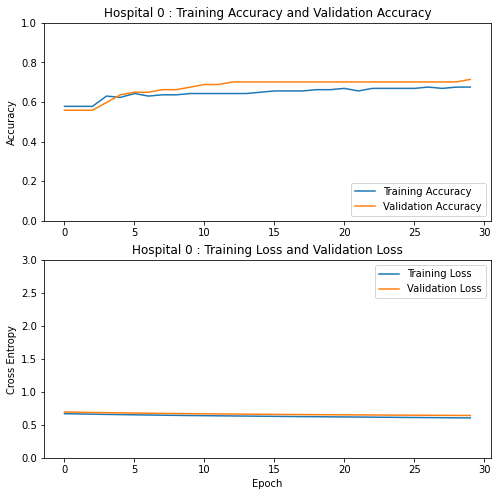

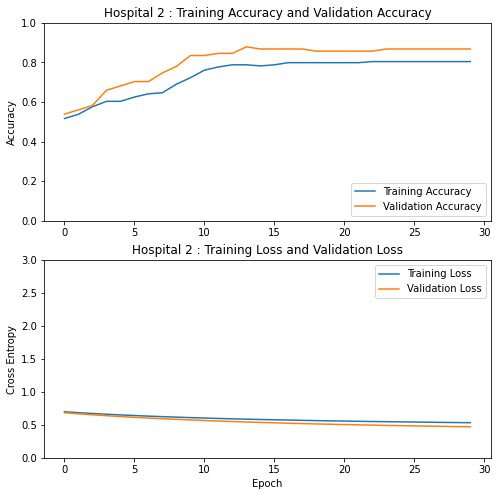

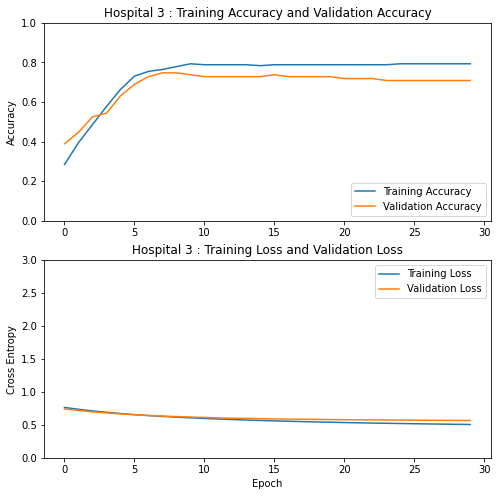

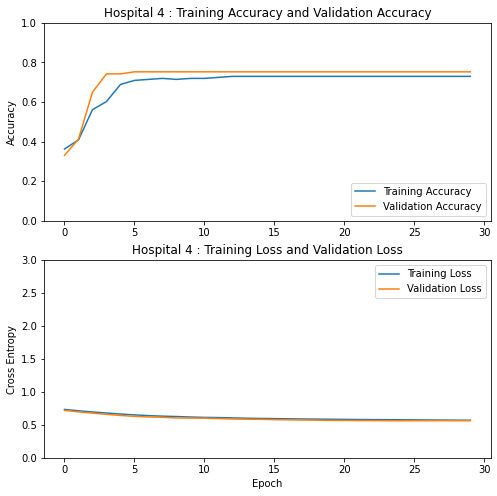

In [35]:
for i in [0,2,3,4]:
    print("\n========== HOSPITAL %d ==========" % i)
    train_loss = d["history_" + str(i)].history['loss']
    train_acc = d["history_" + str(i)].history['binary_accuracy']
    test_loss = d["history_" + str(i)].history['val_loss']
    test_acc = d["history_" + str(i)].history['val_binary_accuracy']
    fig1 = plt.figure(figsize=(8, 8))
    ax1 = fig1.add_subplot(2, 1, 1)
    ax1.plot(train_acc, label='Training Accuracy')
    ax1.plot(test_acc, label='Validation Accuracy')
    ax1.legend(loc='lower right')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim([0, 1])
    ax1.set_title('Hospital %d : Training Accuracy and Validation Accuracy' % i)

    ax2 = fig1.add_subplot(2, 1, 2)
    ax2.plot(train_loss, label='Training Loss')
    ax2.plot(test_loss, label='Validation Loss')
    ax2.legend(loc='upper right')
    ax2.set_ylabel('Cross Entropy')
    ax2.set_ylim([0,3]) #max(ax2.get_ylim())
    ax2.set_title('Hospital %d : Training Loss and Validation Loss' % i )
    ax2.set_xlabel('Epoch')
    
#     plt.savefig('./figures/single-hospital-%d-accuracy_loss.png' % i)
